# Econometria Aplicada

### Assimetria nos efeitos contemporâneos da política monetária brasileira: evidências de regressão quantílica antes, durante e depois da pandemia.

> Motivação

* 

##### Importando as bases

In [2]:
pip install pandas numpy matplotlib statsmodels


  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.9 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 641.7 kB/s eta 0:00:00
  Using cached statsmodels-0.14.5-cp311-cp311-win_amd64.whl.metadata (9.8 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
     -------------------------------------- 115.4/115.4 kB 7.0 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
     ---------------------------------------- 0.0/60


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install quantreg


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement quantreg (from versions: none)
ERROR: No matching distribution found for quantreg

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt

print("Bibliotecas carregadas com sucesso.")


Bibliotecas carregadas com sucesso.


--------------------------------

##### Dados (API do BCB)

In [5]:
# ============================================
# Definição do intervalo de datas e URLs do BCB
# ============================================

# Intervalo de datas
data_inicial = '01/01/2015'
data_final   = '31/12/2024'

# Códigos das séries no SGS:
# 24363 = IBC-Br dessazonalizado
# 1178  = Selic acumulada no mês (%)
# 433   = IPCA variação mensal (%)

url_ibcbr = (
    f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados"
    f"?formato=csv&dataInicial={data_inicial}&dataFinal={data_final}"
)

url_selic = (
    f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados"
    f"?formato=csv&dataInicial={data_inicial}&dataFinal={data_final}"
)

url_ipca = (
    f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados"
    f"?formato=csv&dataInicial={data_inicial}&dataFinal={data_final}"
)

print("\nURLs configuradas com sucesso.")
print("IBC-Br:", url_ibcbr)
print("Selic :", url_selic)
print("IPCA  :", url_ipca)

# ============================================
# Baixar as séries (leitura via pandas)
# ============================================

ibc_raw   = pd.read_csv(url_ibcbr, sep=';')
selic_raw = pd.read_csv(url_selic, sep=';')
ipca_raw  = pd.read_csv(url_ipca,  sep=';')

print("\nPrimeiras linhas de cada série bruta:")

print("\nIBC-Br:")
print(ibc_raw.head())

print("\nSelic:")
print(selic_raw.head())

print("\nIPCA:")
print(ipca_raw.head())



URLs configuradas com sucesso.
IBC-Br: https://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=csv&dataInicial=01/01/2015&dataFinal=31/12/2024
Selic : https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=csv&dataInicial=01/01/2015&dataFinal=31/12/2024
IPCA  : https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=csv&dataInicial=01/01/2015&dataFinal=31/12/2024

Primeiras linhas de cada série bruta:

IBC-Br:
         data      valor
0  01/01/2015   97,57691
1  01/02/2015   96,03743
2  01/03/2015  104,95041
3  01/04/2015   99,98713
4  01/05/2015   98,07784

Selic:
         data  valor
0  02/01/2015  11,65
1  05/01/2015  11,65
2  06/01/2015  11,65
3  07/01/2015  11,65
4  08/01/2015  11,65

IPCA:
         data valor
0  01/01/2015  1,24
1  01/02/2015  1,22
2  01/03/2015  1,32
3  01/04/2015  0,71
4  01/05/2015  0,74


##### Tratamento das séries

In [6]:
# Converter datas
for df_temp in [ibc_raw, selic_raw, ipca_raw]:
    df_temp['data'] = pd.to_datetime(df_temp['data'], dayfirst=True)

# Converter vírgula em ponto e para float
for df_temp in [ibc_raw, selic_raw, ipca_raw]:
    df_temp['valor'] = (
        df_temp['valor']
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

# Agregar Selic (diária em mensal, média do mês)
selic_mensal = (
    selic_raw
    .set_index('data')
    .resample('MS')['valor']
    .mean()
    .reset_index()
    .rename(columns={'valor': 'selic'})
)

# Garantir ibcbr e ipca mensais em freq 'MS'
ibc_mensal = (
    ibc_raw
    .set_index('data')
    .resample('MS')['valor']
    .mean()
    .reset_index()
    .rename(columns={'valor': 'ibcbr'})
)

ipca_mensal = (
    ipca_raw
    .set_index('data')
    .resample('MS')['valor']
    .mean()
    .reset_index()
    .rename(columns={'valor': 'ipca'})
)

# Merge final das três séries
df = (
    ibc_mensal
    .merge(selic_mensal, on='data', how='inner')
    .merge(ipca_mensal, on='data', how='inner')
    .sort_values('data')
    .reset_index(drop=True)
)

print("\nDataFrame tratado - primeiras linhas:")
print(df.head())

print("\nInfo do DataFrame final:")
print(df.info())



DataFrame tratado - primeiras linhas:
        data      ibcbr      selic  ipca
0 2015-01-01   97.57691  11.816667  1.24
1 2015-02-01   96.03743  12.150000  1.22
2 2015-03-01  104.95041  12.581818  1.32
3 2015-04-01   99.98713  12.677500  0.71
4 2015-05-01   98.07784  13.150000  0.74

Info do DataFrame final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    120 non-null    datetime64[ns]
 1   ibcbr   120 non-null    float64       
 2   selic   120 non-null    float64       
 3   ipca    120 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.9 KB
None


--------------------------

##### Regimes pré-pandemia, pandemia e pós-pandemia

In [7]:
# ============================================
# Definição dos períodos (Regimes)
# ============================================

print("\nDefinindo períodos: Pré-pandemia, Pandemia e Pós-pandemia...")

# Começa marcando tudo como "Pré-pandemia"
df['periodo'] = 'Pré-pandemia'

# Pandemia: de mar/2020 até dez/2021
df.loc[(df['data'] >= '2020-03-01') & (df['data'] <= '2021-12-01'), 'periodo'] = 'Pandemia'

# Pós-pandemia: a partir de jan/2022
df.loc[df['data'] >= '2022-01-01', 'periodo'] = 'Pós-pandemia'

print("\nObservações por período:")
print(df['periodo'].value_counts().sort_index())

print("\nExemplo das primeiras linhas com a coluna 'periodo':")
print(df.head(10))



Definindo períodos: Pré-pandemia, Pandemia e Pós-pandemia...

Observações por período:
periodo
Pandemia        22
Pré-pandemia    62
Pós-pandemia    36
Name: count, dtype: int64

Exemplo das primeiras linhas com a coluna 'periodo':
        data      ibcbr      selic  ipca       periodo
0 2015-01-01   97.57691  11.816667  1.24  Pré-pandemia
1 2015-02-01   96.03743  12.150000  1.22  Pré-pandemia
2 2015-03-01  104.95041  12.581818  1.32  Pré-pandemia
3 2015-04-01   99.98713  12.677500  0.71  Pré-pandemia
4 2015-05-01   98.07784  13.150000  0.74  Pré-pandemia
5 2015-06-01   97.17881  13.578571  0.79  Pré-pandemia
6 2015-07-01  100.45103  13.693478  0.62  Pré-pandemia
7 2015-08-01   98.77738  14.150000  0.22  Pré-pandemia
8 2015-09-01   96.88151  14.150000  0.54  Pré-pandemia
9 2015-10-01   98.36907  14.150000  0.82  Pré-pandemia


##### Interpretando o output acima:
* A segmentação temporal cria **três regimes econômicos** distintos: um período pré-pandemia relativamente estável (62 meses), o choque macroeconômico associado à pandemia (22 meses) e o período pós-pandemia caracterizado por forte normalização monetária (36 meses);

* O tamanho desigual dos intervalos reflete a natureza econômica dos regimes, não a duração epidemiológica da pandemia;

* Essa classificação é fundamental para avaliar assimetrias nos efeitos da Selic, pois cada regime representa uma dinâmica econômica diferente, permitindo comparar a eficácia da política monetária antes, durante e depois do choque pandêmico.

##### Criação dos dataframes por período

In [8]:
# ============================================
# Criação dos dataframes por período
# ============================================

df_pre  = df[df['periodo'] == 'Pré-pandemia'].copy()
df_pan  = df[df['periodo'] == 'Pandemia'].copy()
df_pos  = df[df['periodo'] == 'Pós-pandemia'].copy()

print("\nTamanhos de cada dataframe:")
print("Pré-pandemia:", df_pre.shape)
print("Pandemia    :", df_pan.shape)
print("Pós-pandemia:", df_pos.shape)



Tamanhos de cada dataframe:
Pré-pandemia: (62, 5)
Pandemia    : (22, 5)
Pós-pandemia: (36, 5)


---------------------------------

Antes de aplicar a regressão quantílica, estimei a regressão linear múltipla como benchmark tradicional da econometria. Apesar de indicar alguma relação negativa entre Selic e atividade no pós-pandemia, o modelo apresenta baixo poder explicativo e não captura a heterogeneidade presente nos resíduos e nas caudas da distribuição. Esses resultados motivam o uso da regressão quantílica para investigar assimetrias ao longo dos diferentes níveis do IBC-Br.

##### Regressão Linear Múltipla (OLS) por período

In [26]:
# Fórmula do modelo
formula = "ibcbr ~ selic + ipca"

# Estimar modelos por período
modelo_pre = smf.ols(formula, data=df_pre).fit()
modelo_pan = smf.ols(formula, data=df_pan).fit()
modelo_pos = smf.ols(formula, data=df_pos).fit()

print("\n================ OLS MÚLTIPLA - PRÉ-PANDEMIA ================")
print(modelo_pre.summary())

print("\n================ OLS MÚLTIPLA - PANDEMIA ================")
print(modelo_pan.summary())

print("\n================ OLS MÚLTIPLA - PÓS-PANDEMIA ================")
print(modelo_pos.summary())

# Tabela-resumo dos coeficientes (pra usar no relatório)
tabela_ols = pd.DataFrame({
    "Período": ["Pré-pandemia", "Pandemia", "Pós-pandemia"],
    "Intercepto": [
        modelo_pre.params["Intercept"],
        modelo_pan.params["Intercept"],
        modelo_pos.params["Intercept"],
    ],
    "Beta_selic": [
        modelo_pre.params["selic"],
        modelo_pan.params["selic"],
        modelo_pos.params["selic"],
    ],
    "Beta_ipca": [
        modelo_pre.params["ipca"],
        modelo_pan.params["ipca"],
        modelo_pos.params["ipca"],
    ],
    "R2": [
        modelo_pre.rsquared,
        modelo_pan.rsquared,
        modelo_pos.rsquared,
    ]
})

print("\n===== TABELA-RESUMO OLS MÚLTIPLA (coeficientes) =====")
print(tabela_ols.round(4))



================ OLS MÚLTIPLA - PRÉ-PANDEMIA ================
                            OLS Regression Results                            
Dep. Variable:                  ibcbr   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7637
Date:                Sat, 29 Nov 2025   Prob (F-statistic):              0.470
Time:                        03:33:10   Log-Likelihood:                -150.93
No. Observations:                  62   AIC:                             307.9
Df Residuals:                      59   BIC:                             314.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### Interpretando o output acima:
* Pré-pandemia: coeficientes pequenos e não significativos, com R² muito baixo — indicando que Selic e IPCA pouco explicam o nível de atividade em um regime estável.

* Pandemia: o IPCA se torna significativo e dominante, enquanto a Selic permanece irrelevante — refletindo um período de choque em que a política monetária perde tração.

* Pós-pandemia: a Selic assume coeficiente negativo relevante (ainda que não significativo a 5%), e o R² melhora um pouco — sugerindo retorno gradual da eficácia da política monetária, mas ainda com heterogeneidade não capturada pela média do modelo.


##### Painel 1 - Scatter + Reta OLS

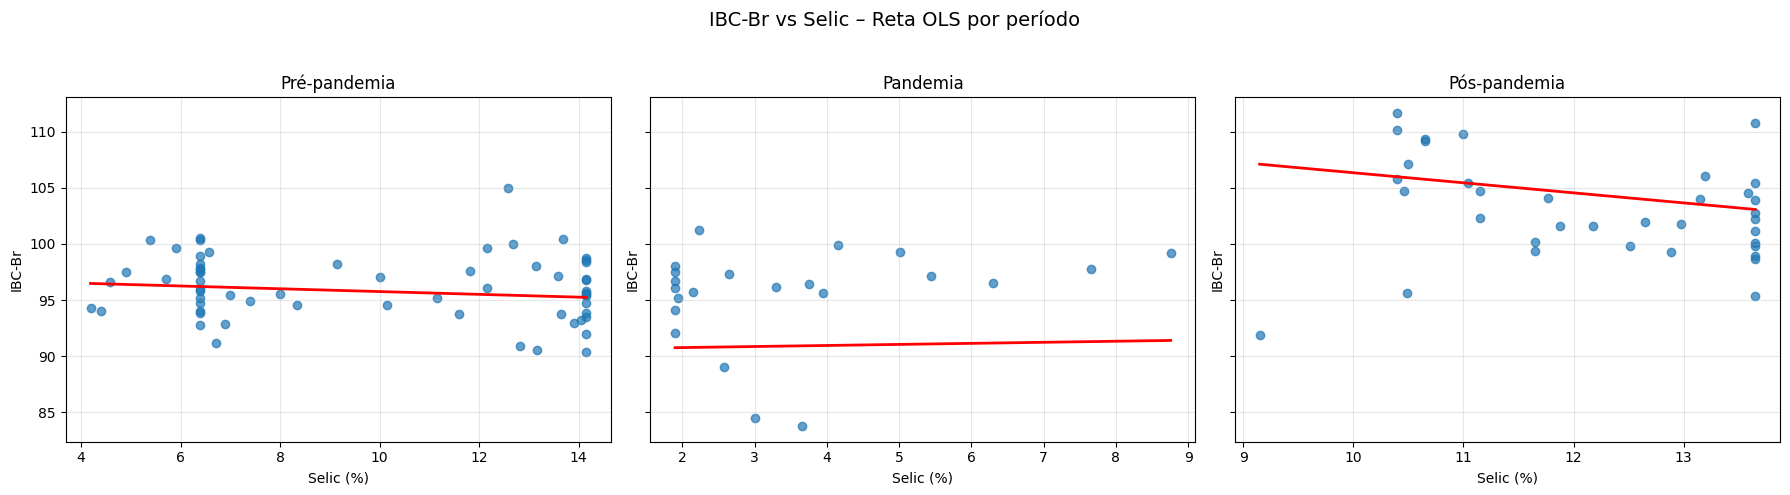

In [23]:

def scatter_com_reta(ax, df_periodo, modelo, titulo):
    beta0 = modelo.params['Intercept']
    beta1 = modelo.params['selic']

    selic_range = np.linspace(df_periodo['selic'].min(),
                              df_periodo['selic'].max(), 100)
    reta = beta0 + beta1 * selic_range

    ax.scatter(df_periodo['selic'], df_periodo['ibcbr'],
               alpha=0.7, label="Observado")
    ax.plot(selic_range, reta, color='red', linewidth=2.0, label='OLS')

    ax.set_title(titulo)
    ax.set_xlabel("Selic (%)")
    ax.set_ylabel("IBC-Br")
    ax.grid(alpha=0.3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

scatter_com_reta(axes[0], df_pre,  modelo_pre, "Pré-pandemia")
scatter_com_reta(axes[1], df_pan,  modelo_pan, "Pandemia")
scatter_com_reta(axes[2], df_pos,  modelo_pos, "Pós-pandemia")

plt.suptitle("IBC-Br vs Selic – Reta OLS por período", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### Interpretação do output acima:

* Pré-pandemia: A reta praticamente horizontal indica ausência de relação contemporânea entre Selic e IBC-Br. Mesmo com variação da taxa de juros, o nível de atividade permanece distribuído sem padrão claro, sugerindo que a política monetária tinha baixa tração nesse período estável.

* Pandemia: A dispersão elevada dos pontos e a reta quase plana refletem um regime dominado por choques exógenos, onde a Selic perde capacidade explicativa. A atividade econômica apresenta comportamento desordenado, coerente com a natureza excepcional desse período.

* Pós-pandemia: A inclinação negativa da reta torna-se visível, indicando que aumentos na Selic estão associados a reduções na atividade. A relação fica mais estruturada e consistente, evidenciando o retorno da eficácia da política monetária e antecipando o padrão assimétrico observado na regressão quantílica.

##### Painel 2 - Resíduos versus Fitted

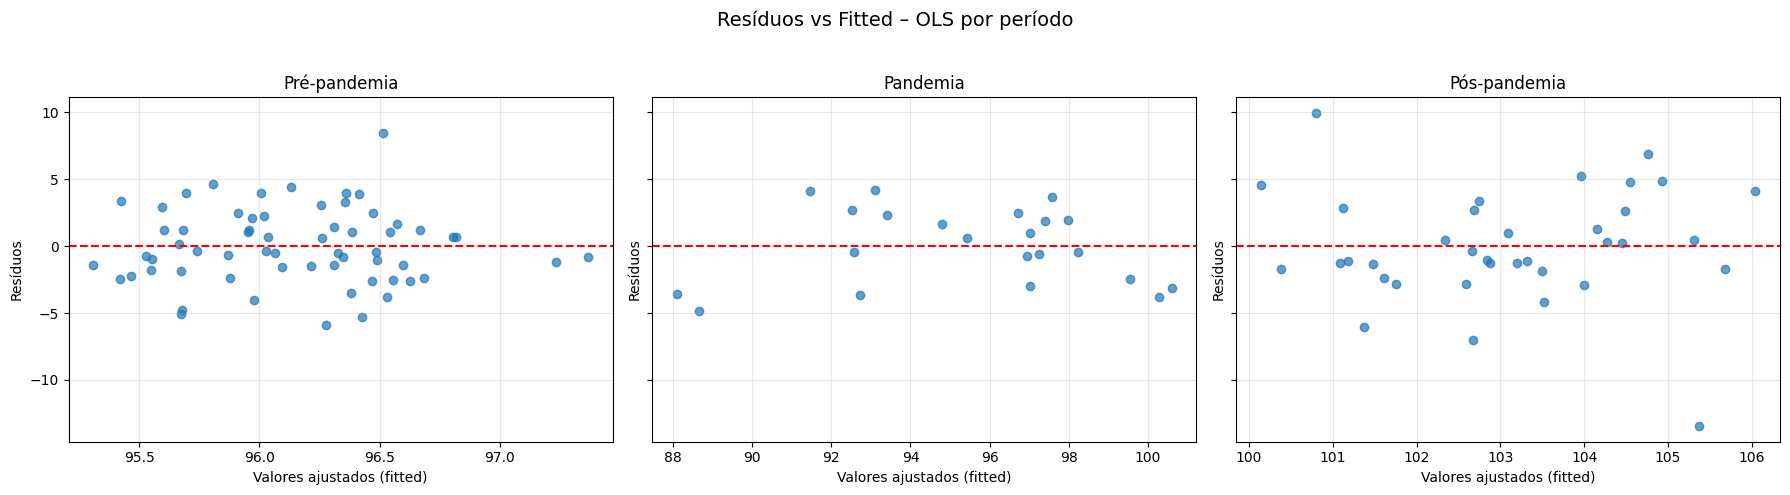

In [24]:

def plot_residuos(ax, modelo, titulo):
    resid = modelo.resid
    fitted = modelo.fittedvalues

    ax.scatter(fitted, resid, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5)

    ax.set_title(titulo)
    ax.set_xlabel("Valores ajustados (fitted)")
    ax.set_ylabel("Resíduos")
    ax.grid(alpha=0.3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

plot_residuos(axes[0], modelo_pre, "Pré-pandemia")
plot_residuos(axes[1], modelo_pan, "Pandemia")
plot_residuos(axes[2], modelo_pos, "Pós-pandemia")

plt.suptitle("Resíduos vs Fitted – OLS por período", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### Interpretando o output acima:

* Pré-pandemia: Resíduos dispersos, mas sem padrão estrutural — coerente com um regime estável onde a relação Selic–atividade é fraca.

* Pandemia: Resíduos mais irregulares, indicando quebra estrutural e baixa capacidade explicativa do modelo nesse período atípico.

* Pós-pandemia: Resíduos mais organizados, mas com sinais de não linearidade — sugerindo que a OLS captura apenas parte da relação, justificando o uso de regressão quantílica.

##### Painel 3 - Q-Q Plot dos resíduos

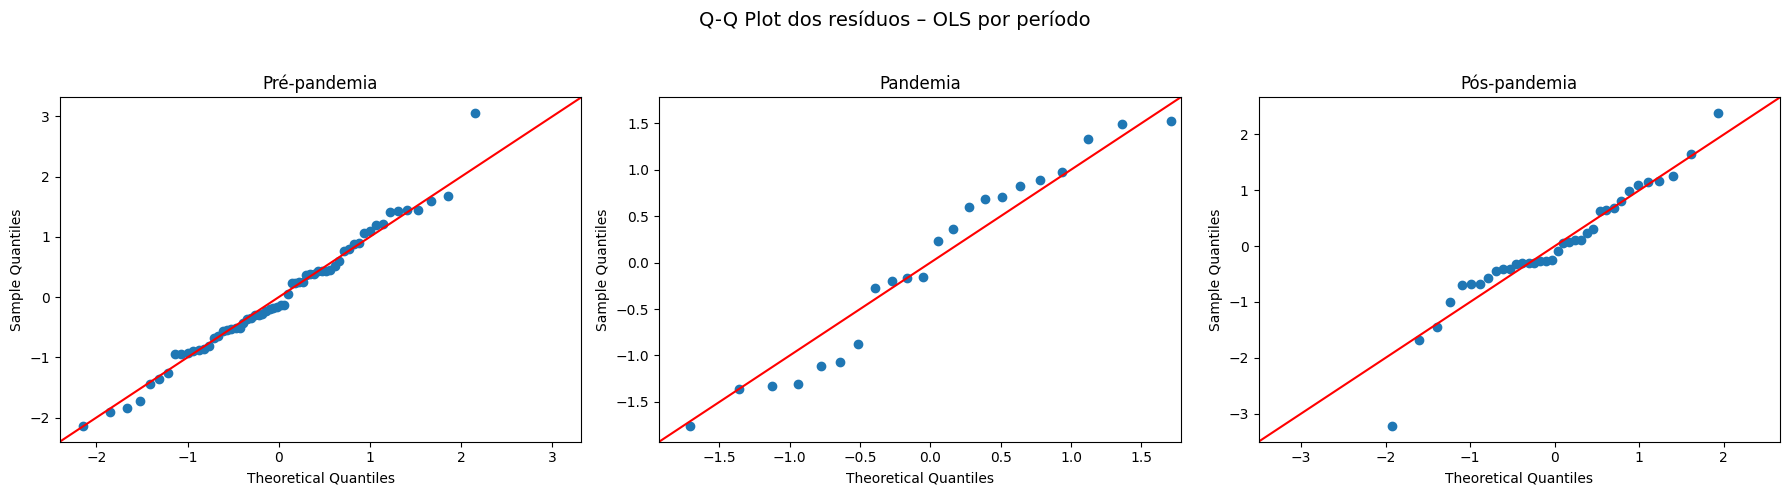

In [25]:

def qqplot_residuos(ax, modelo, titulo):
    sm.qqplot(modelo.resid, line='45', ax=ax, fit=True)
    ax.set_title(titulo)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

qqplot_residuos(axes[0], modelo_pre, "Pré-pandemia")
qqplot_residuos(axes[1], modelo_pan, "Pandemia")
qqplot_residuos(axes[2], modelo_pos, "Pós-pandemia")

plt.suptitle("Q-Q Plot dos resíduos – OLS por período", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### Interpretando o output acima:

* Pré-pandemia: Resíduos bem alinhados à distribuição normal, sugerindo que a OLS funciona adequadamente nesse regime mais estável.

* Pandemia: Desvios claros da normalidade, sobretudo nas caudas, indicando ruptura estrutural e baixa adequação do modelo linear.

* Pós-pandemia: Ajuste mais próximo do normal no centro, mas com caudas distorcidas — sinal de que ainda há heterogeneidade não capturada pela OLS, justificando o uso da regressão quantílica.

---------------

Como a OLS múltipla fornece apenas uma estimativa média e não captura a heterogeneidade evidente entre períodos e níveis da atividade, aplicamos regressão quantílica para examinar possíveis efeitos assimétricos da Selic ao longo da distribuição do IBC-Br.

##### Pergunta a ser respondida

• Como o impacto da taxa Selic sobre o nível de atividade econômica (IBC-Br) varia ao longo da distribuição condicional do IBC-Br (quantis) nos regimes pré-pandemia, pandemia e pós-pandemia?

##### Equação do modelo econométrico proposto

O modelo estimado para cada quantil τ é:

Qτ(IBCBrₜ | Selicₜ, IPCAₜ) = β₀,τ

β₁,τ · Selicₜ

β₂,τ · IPCAₜ

Onde:

• Qτ(IBCBrₜ | ·) é o quantil τ da distribuição condicional do IBC-Br.

• β₀,τ é o intercepto específico do quantil.

• β₁,τ é o coeficiente da Selic no quantil τ (captura o efeito assimétrico da política monetária).

• β₂,τ é o coeficiente do IPCA no quantil τ.

Estimamos esse modelo separadamente para cada um dos três períodos: pré-pandemia, pandemia e pós-pandemia.


##### Regressão Quantílíca no período pré, pandemia e pós

In [11]:
# ============================================
# Função para rodar regressão quantílica
# ============================================

def rodar_quantil(df_periodo, nome_periodo, quantis):
    """
    Roda regressões quantílicas ibcbr ~ selic + ipca para um período.
    
    Retorna um dataframe com:
    - quantil
    - coef_selic
    - coef_ipca
    - intercepto
    - nome_periodo
    """
    print(f"\n===== Regressão Quantílica - {nome_periodo} =====")
    
    resultados = []
    
    # X com constante
    X = sm.add_constant(df_periodo[['selic', 'ipca']])
    y = df_periodo['ibcbr']
    
    for q in quantis:
        mod = QuantReg(y, X)
        res = mod.fit(q=q)
        
        print(f"\n--- Quantil τ = {q} ({nome_periodo}) ---")
        print(res.summary())
        
        resultados.append({
            'periodo': nome_periodo,
            'quantil': q,
            'intercepto': res.params['const'],
            'beta_selic': res.params['selic'],
            'beta_ipca': res.params['ipca']
        })
    
    return pd.DataFrame(resultados)


# ============================================
# Definição da estimativa dos quantis
# ============================================

quantis = [0.10, 0.25, 0.50, 0.75, 0.90]


# ============================================
# Quantílica para cada período
# ============================================

resultados_quant_pre = rodar_quantil(df_pre, "Pré-pandemia", quantis)
resultados_quant_pan = rodar_quantil(df_pan, "Pandemia", quantis)
resultados_quant_pos = rodar_quantil(df_pos, "Pós-pandemia", quantis)

# Juntar tudo em um único DF (para gráfico e tabela depois)
resultados_quant = pd.concat(
    [resultados_quant_pre, resultados_quant_pan, resultados_quant_pos],
    ignore_index=True
)

print("\n===== PRIMEIRAS LINHAS DOS RESULTADOS QUANTÍLICOS =====")
print(resultados_quant.head())



===== Regressão Quantílica - Pré-pandemia =====

--- Quantil τ = 0.1 (Pré-pandemia) ---
                         QuantReg Regression Results                          
Dep. Variable:                  ibcbr   Pseudo R-squared:              0.06065
Model:                       QuantReg   Bandwidth:                       3.779
Method:                 Least Squares   Sparsity:                        12.54
Date:                Fri, 28 Nov 2025   No. Observations:                   62
Time:                        23:15:58   Df Residuals:                       59
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0519      1.622     58.612      0.000      91.807      98.297
selic         -0.1211      0.162     -0.746      0.458      -0.446       0.204
ipca          -2.3420      1.354     -1.72

c:\Users\giovanna.araujo_rede\Desktop\Projetos\econometria-aplicada\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


##### Interpretando o output acima:

• No período pré-pandemia, os coeficientes quantílicos da Selic e do IPCA são pequenos e não significativos em todos os quantis, indicando **ausência de efeito contemporâneo relevante da política monetária** ao longo da distribuição do IBC-Br.

• Durante a pandemia, a regressão quantílica mostra **maior sensibilidade do IBC-Br a choques de inflação em alguns quantis (especialmente superiores)**, enquanto a Selic permanece sem efeito significativo, refletindo um regime dominado por choques reais e desorganização econômica.

• No período pós-pandemia, a Selic exibe coeficientes negativos, significativos e crescentes em magnitude à medida que avançamos para quantis mais altos do IBC-Br, o que **sugere que a política monetária se torna mais eficaz em conter a atividade quando a economia está em níveis mais elevados** – evidência clara de assimetria nos efeitos da política monetária.


##### Coeficiente da SELIC por Quantil e período

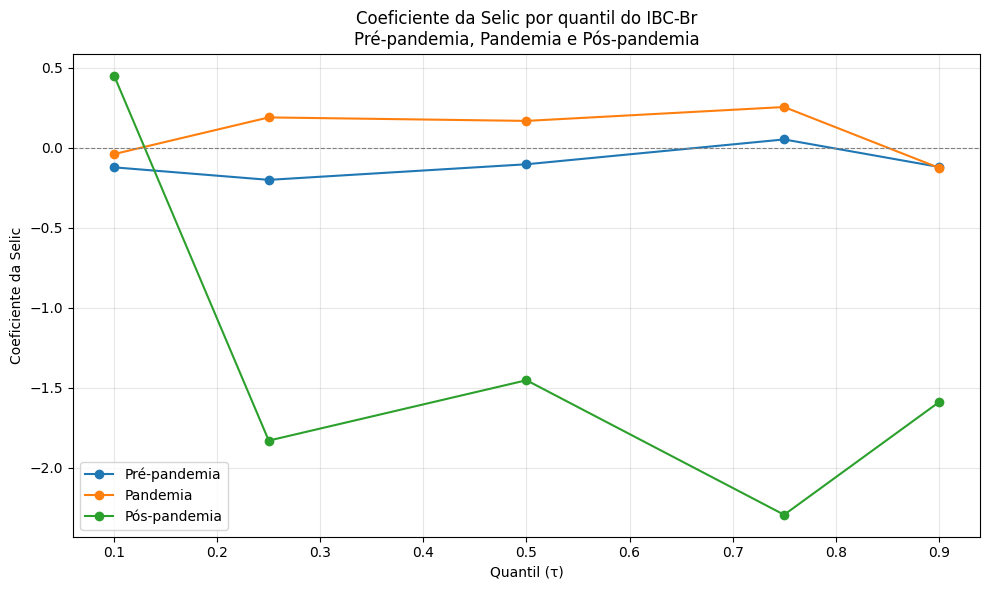

In [12]:
# ============================================
# Gráfico dos coeficientes da Selic por quantil e período
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for nome_periodo in ['Pré-pandemia', 'Pandemia', 'Pós-pandemia']:
    subset = resultados_quant[resultados_quant['periodo'] == nome_periodo]
    plt.plot(
        subset['quantil'],
        subset['beta_selic'],
        marker='o',
        label=nome_periodo
    )

plt.xlabel('Quantil (τ)')
plt.ylabel('Coeficiente da Selic')
plt.title('Coeficiente da Selic por quantil do IBC-Br\nPré-pandemia, Pandemia e Pós-pandemia')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


interpretação:

Pré-pandemia: o coeficiente da Selic permanece próximo de zero em todos os quantis → política monetária não tem efeito contemporâneo nesse regime estável.

Pandemia: os coeficientes também ficam próximos de zero → a política monetária perde tração diante do choque pandêmico.

Pós-pandemia: a Selic torna-se negativa e mais intensa nos quantis superiores, indicando que a política monetária volta a ser eficaz e atua mais fortemente quando a economia está aquecida.

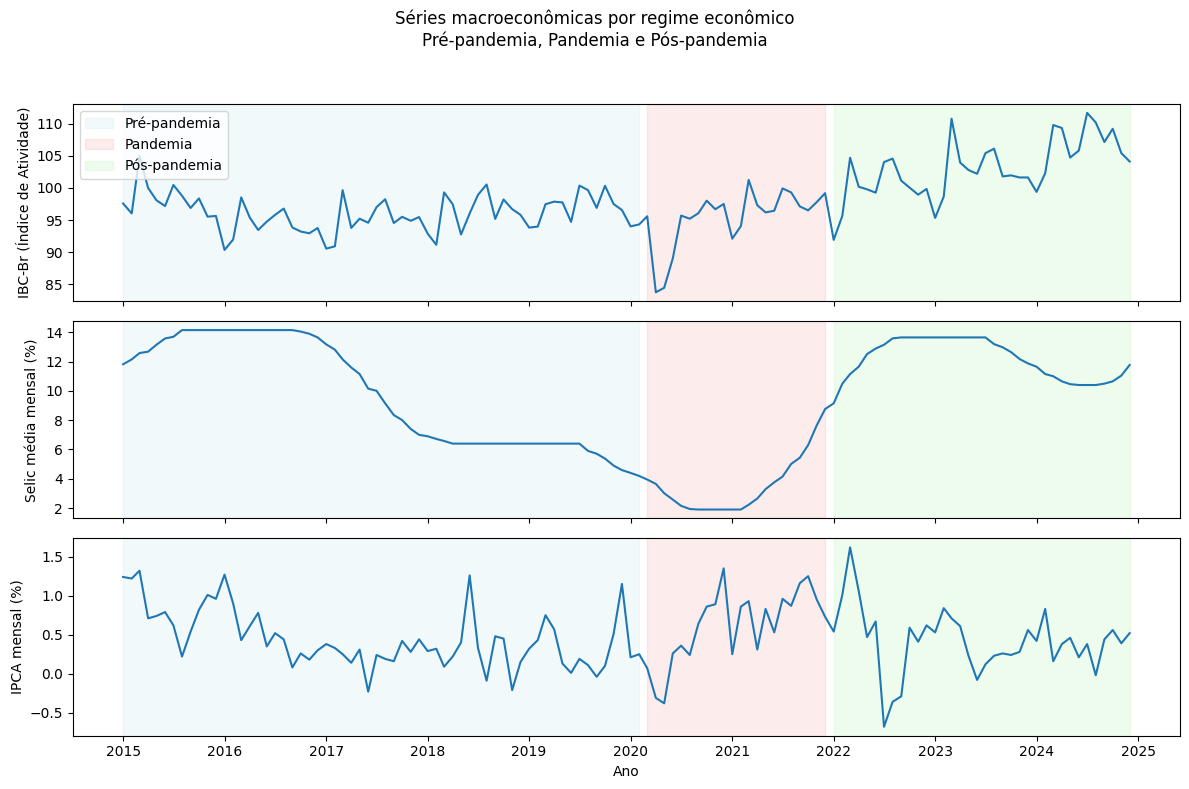

In [13]:
# ============================================
# Painel: IBC-Br, Selic e IPCA vs Regimes
# ============================================

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Cores dos períodos
cores_periodos = {
    'Pré-pandemia': 'lightblue',
    'Pandemia': 'lightcoral',
    'Pós-pandemia': 'lightgreen'
}

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

series = [
    ('ibcbr', 'IBC-Br (Índice de Atividade)'),
    ('selic', 'Selic média mensal (%)'),
    ('ipca', 'IPCA mensal (%)')
]

for ax, (col, titulo) in zip(axes, series):
    # fundo colorido por período
    for periodo, cor in cores_periodos.items():
        mask = df['periodo'] == periodo
        if not mask.any():
            continue
        xmin = df.loc[mask, 'data'].min()
        xmax = df.loc[mask, 'data'].max()
        ax.axvspan(xmin, xmax, color=cor, alpha=0.15, label=periodo)

    # série
    ax.plot(df['data'], df[col], linewidth=1.5)
    ax.set_ylabel(titulo)

# Arrumar legenda (só uma vez)
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(), loc='upper left')

# Formato de data bonitinho no eixo x
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Ano')
plt.suptitle('Séries macroeconômicas por regime econômico\nPré-pandemia, Pandemia e Pós-pandemia')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
